<a href="https://colab.research.google.com/github/syedahafsa135/Multiple_Disease_Prediction_System/blob/main/Diabetes_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score
from zipfile import ZipFile

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.stats import zscore
from statsmodels.stats import weightstats as wstat
from scipy.stats.mstats import winsorize
from sklearn.metrics import precision_score, recall_score, f1_score

Zipping the Files

In [44]:
file_paths=[]
for root,directories,files in os.walk('/content/drive/MyDrive/Should Zip(1)'):
  for file in files:
    file_paths.append(os.path.join(root,file))
with ZipFile('/content/drive/MyDrive/zip(1).zip','w') as zip:
  for file in file_paths:
    zip.write(file)

In [45]:
# loading the diabetes dataset to a pandas DataFrame
diabetes_dataset = pd.read_csv('/content/drive/MyDrive/Should Zip(1)/diabetes.csv')

# **Data Cleaning**


In [46]:
df = pd.read_csv('/content/drive/MyDrive/Should Zip(1)/diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [47]:
columns_to_replace = ['Glucose', 'BloodPressure', 'SkinThickness', 'BMI']
df['Pregnancies'] = np.where(df['Pregnancies'] > 10, 10, df['Pregnancies'])

# Replace zero values with the calculated mean for specified columns
for column in columns_to_replace:
    mean_value = df[df[column] != 0][column].mean()
    df[column] = df[column].replace(0, mean_value)

# Replace only zero values in the 'Insulin' column with the mean for diabetic patients
mean_insulin_diabetic = df.loc[df['Outcome'] == 1, 'Insulin'].mean()
df['Insulin'] = np.where(df['Insulin'] == 0, mean_insulin_diabetic, df['Insulin'])

# Display the first few rows of the cleaned DataFrame
df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.00000,100.335821,33.6,0.627,50,1
1,1,85.0,66.0,29.00000,100.335821,26.6,0.351,31,0
2,8,183.0,64.0,29.15342,100.335821,23.3,0.672,32,1
3,1,89.0,66.0,23.00000,94.000000,28.1,0.167,21,0
4,0,137.0,40.0,35.00000,168.000000,43.1,2.288,33,1


In [48]:
rows_with_nulls = df[df.isnull().any(axis=1)]

In [49]:
null_summary = df.isnull().sum()
null_summary = null_summary[null_summary > 0]
print(null_summary)

Series([], dtype: int64)


In [50]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.00000,100.335821,33.6,0.627,50,1
1,1,85.0,66.0,29.00000,100.335821,26.6,0.351,31,0
2,8,183.0,64.0,29.15342,100.335821,23.3,0.672,32,1
3,1,89.0,66.0,23.00000,94.000000,28.1,0.167,21,0
4,0,137.0,40.0,35.00000,168.000000,43.1,2.288,33,1


**Exploratory Data Analysis (EDA)**

In [51]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.742188,3.123898,0.000,1.000000,3.000000,6.00000,10.00
Glucose,768.0,121.686763,30.435949,44.000,99.750000,117.000000,140.25000,199.00
BloodPressure,768.0,72.405184,12.096346,24.000,64.000000,72.202592,80.00000,122.00
SkinThickness,768.0,29.153420,8.790942,7.000,25.000000,29.153420,32.00000,99.00
Insulin,768.0,128.660934,89.393329,14.000,100.335821,100.335821,127.25000,846.00
BMI,768.0,32.457464,6.875151,18.200,27.500000,32.400000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.243750,0.372500,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.000000,29.000000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.000000,0.000000,1.00000,1.00


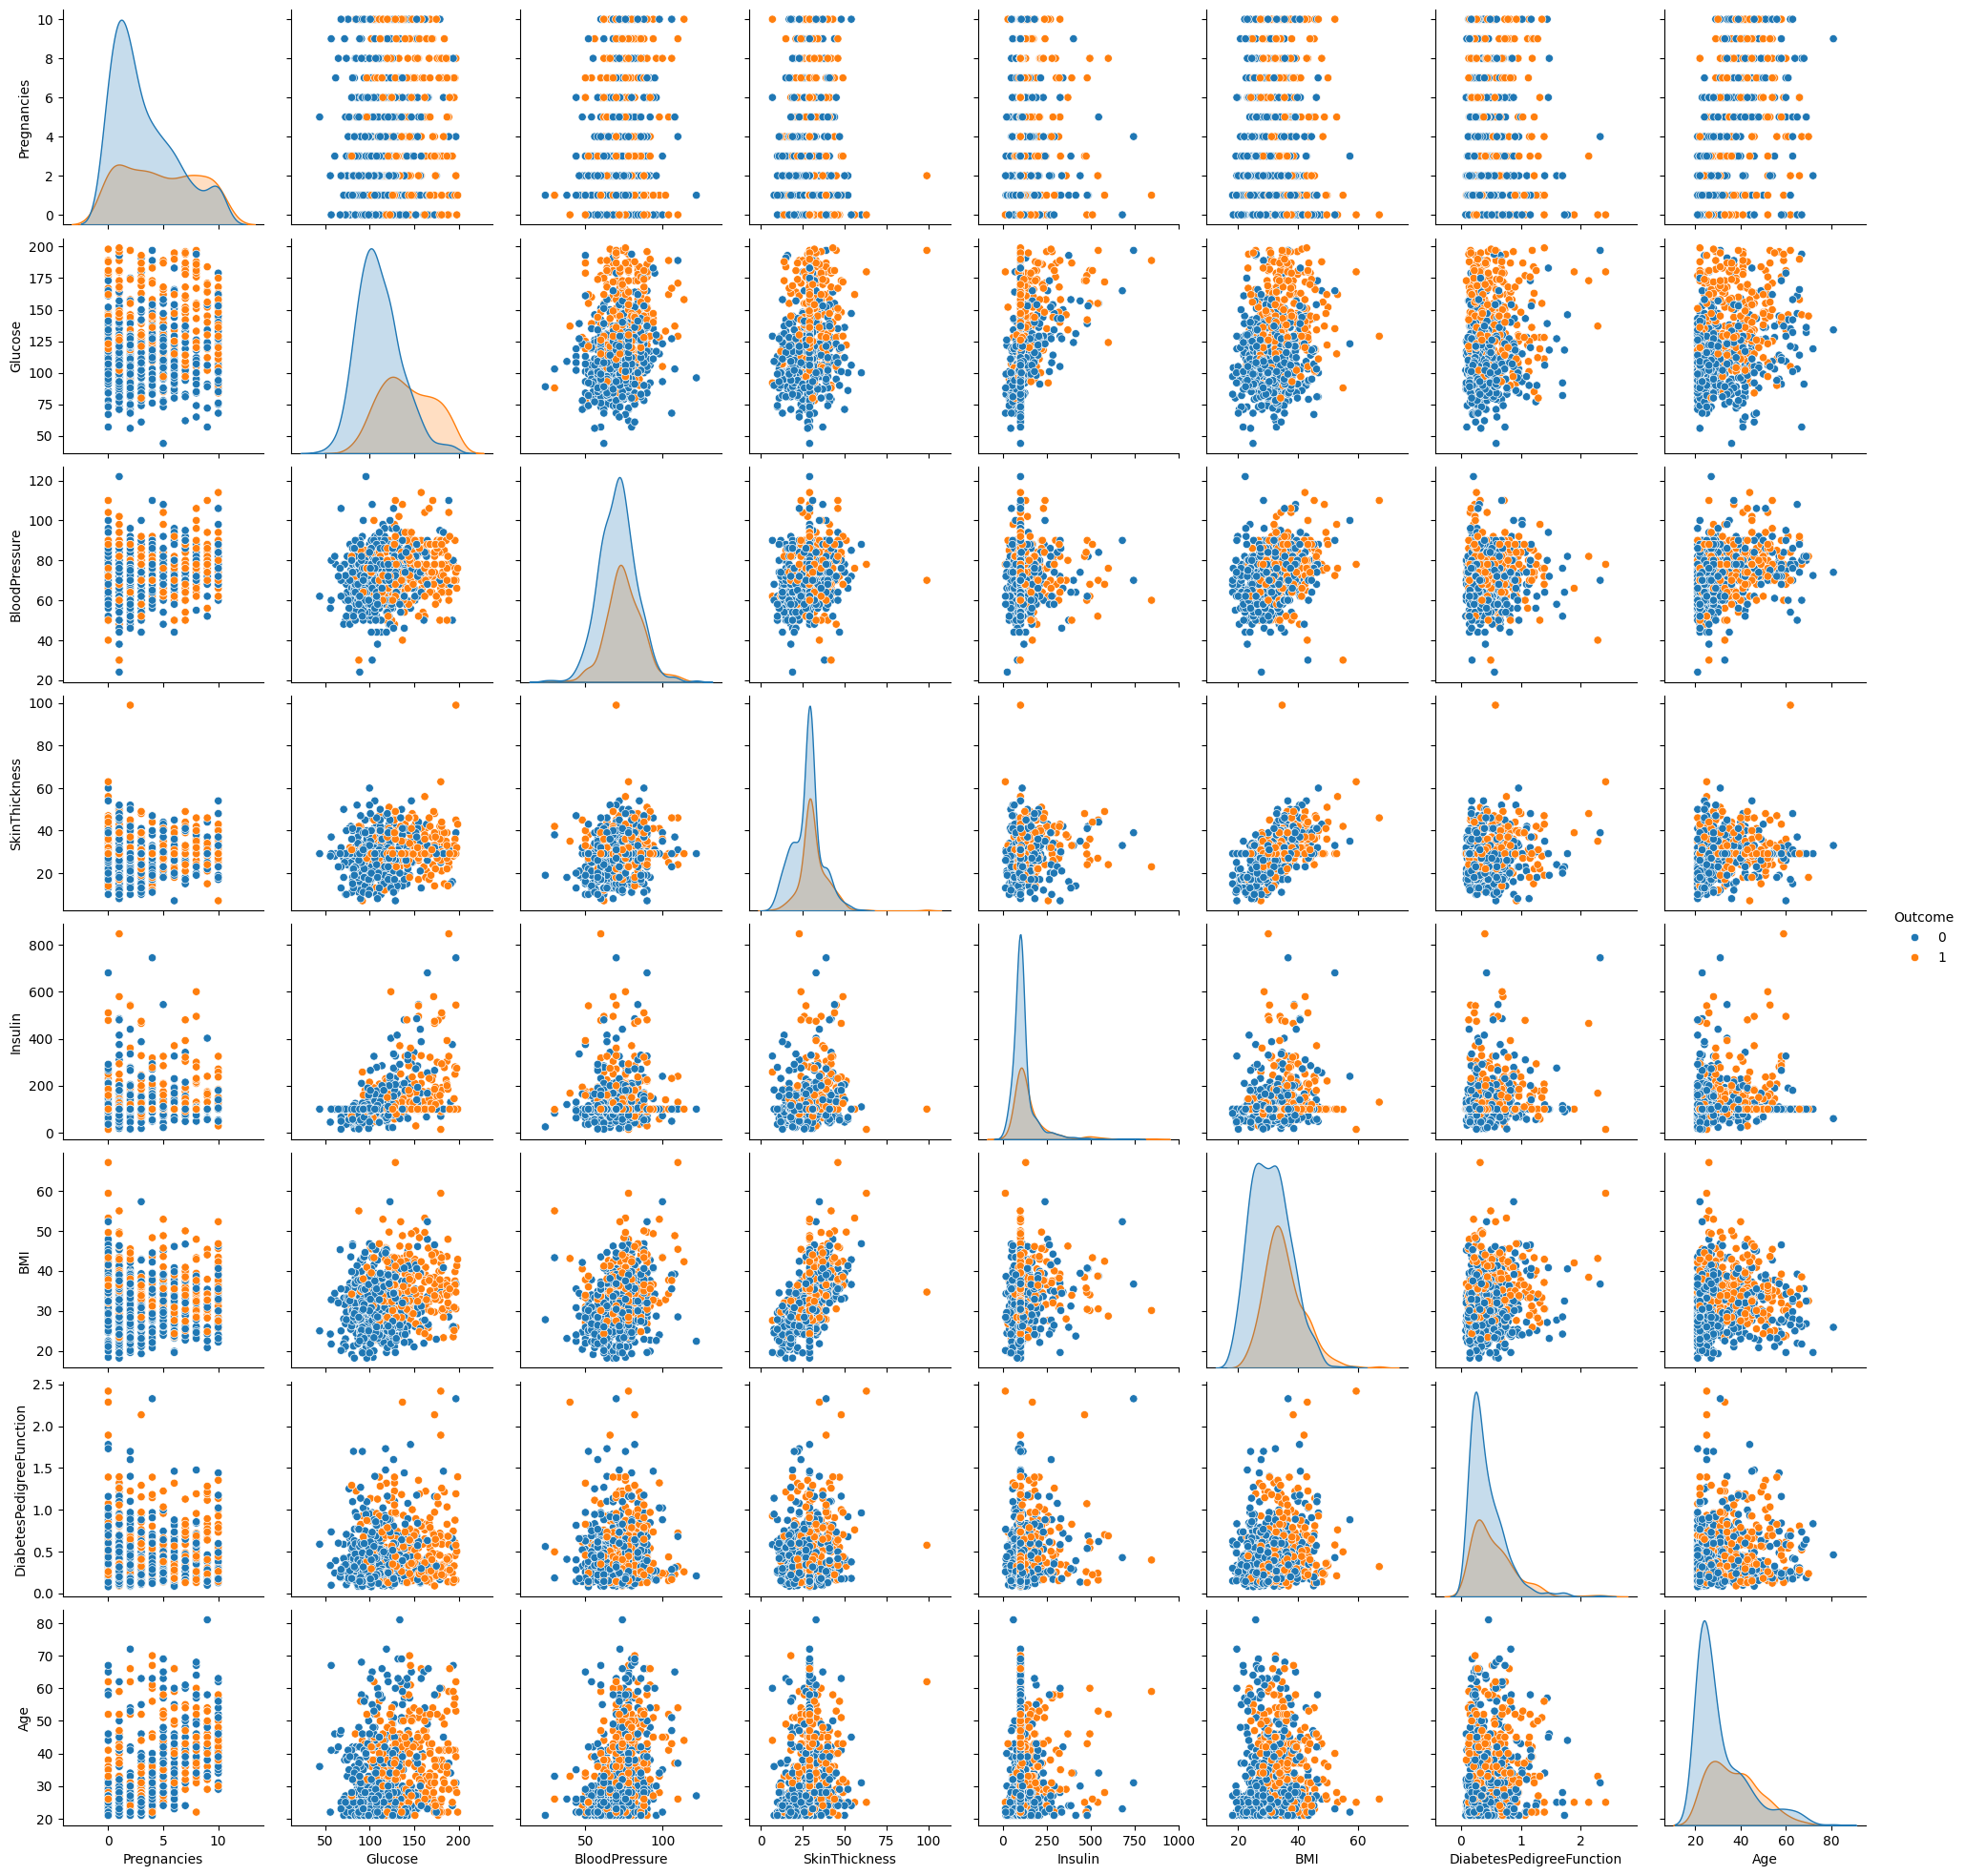

In [52]:
%matplotlib inline
sns.pairplot(data=df, diag_kind='kde', hue='Outcome')
plt.show()


In [53]:
import plotly.graph_objects as go

fig = go.Figure()
my_cols = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

for col in my_cols:
    fig.add_trace(go.Box(y=df[col], name=col))

fig.show()


**Data** **Visualization**

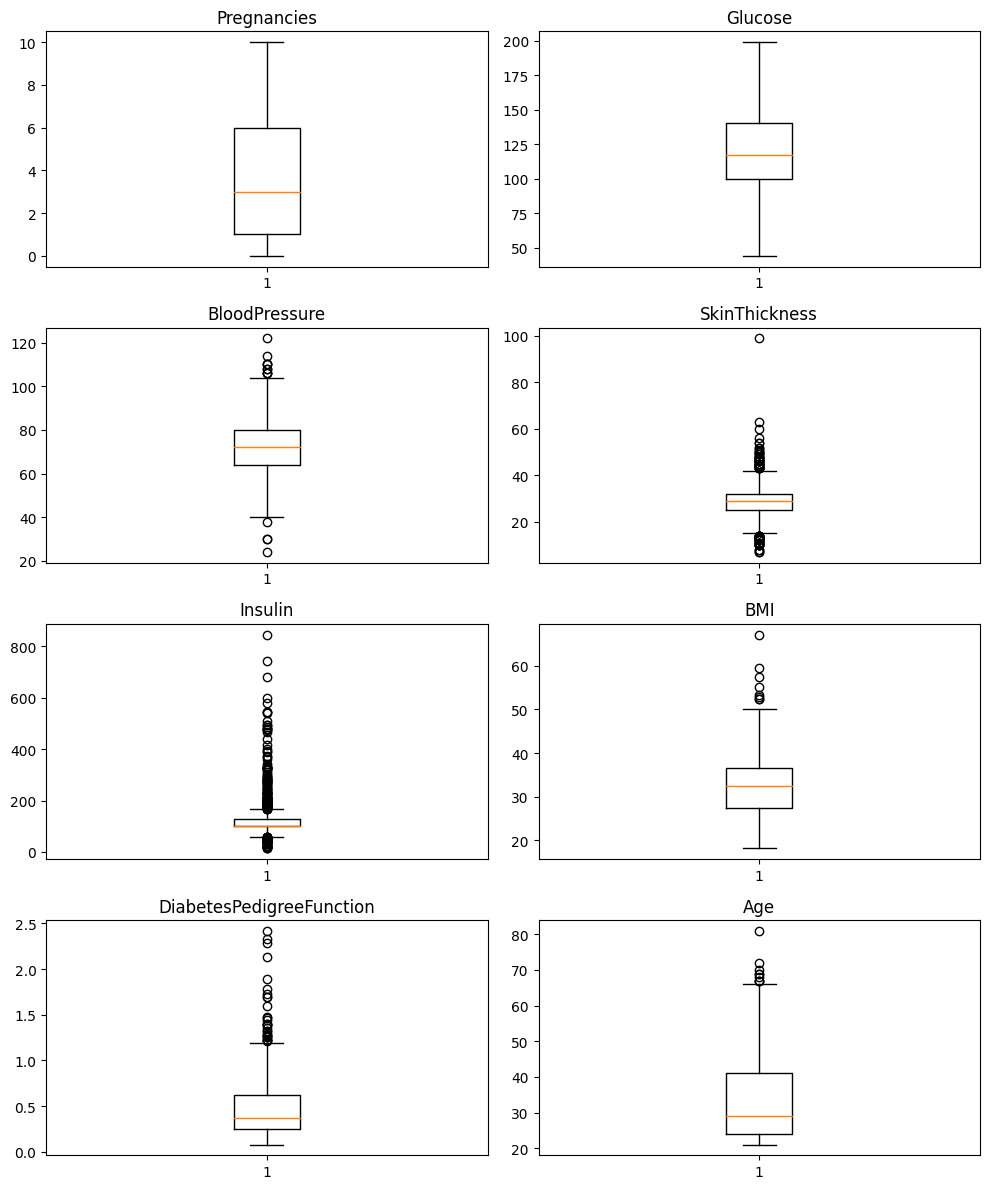

In [54]:
def plot_boxplots(df, columns, columns_per_row=2):
    num_columns = len(columns)
    num_rows = (num_columns + columns_per_row - 1) // columns_per_row

    fig, axes = plt.subplots(num_rows, columns_per_row, figsize=(10, num_rows * 3))
    axes = axes.flatten()

    for i, column in enumerate(columns):
        axes[i].boxplot(df[column].dropna())
        axes[i].set_title(column)

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Columns to plot, excluding 'Outcome'
columns = df.columns[:-1]

# Call the function to plot boxplots
plot_boxplots(df, columns=columns, columns_per_row=2)

In [55]:
# Select only numeric columns from the DataFrame
numeric_df = df.select_dtypes(include='number')

# Calculate z-scores for the numeric DataFrame
z_scores = zscore(numeric_df)

# Detect outliers
outliers = (np.abs(z_scores) > 3)

# Count outliers for each column
outlier_counts = pd.DataFrame(outliers.sum(), columns=['Outlier Count'])

# Display the DataFrame
outlier_counts

,Outlier Count
Pregnancies,0
Glucose,0
BloodPressure,8
SkinThickness,4
Insulin,20
BMI,5
DiabetesPedigreeFunction,11
Age,5
Outcome,0


In [56]:
winsored_df = df.apply(lambda x: winsorize(x, limits=0.05))
columns = winsored_df.columns

<Axes: >

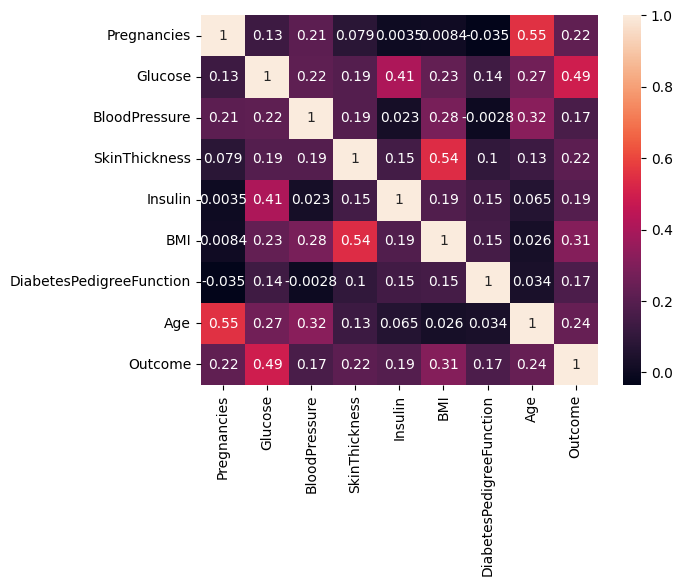

In [57]:
sns.heatmap(df.corr(), annot=True)

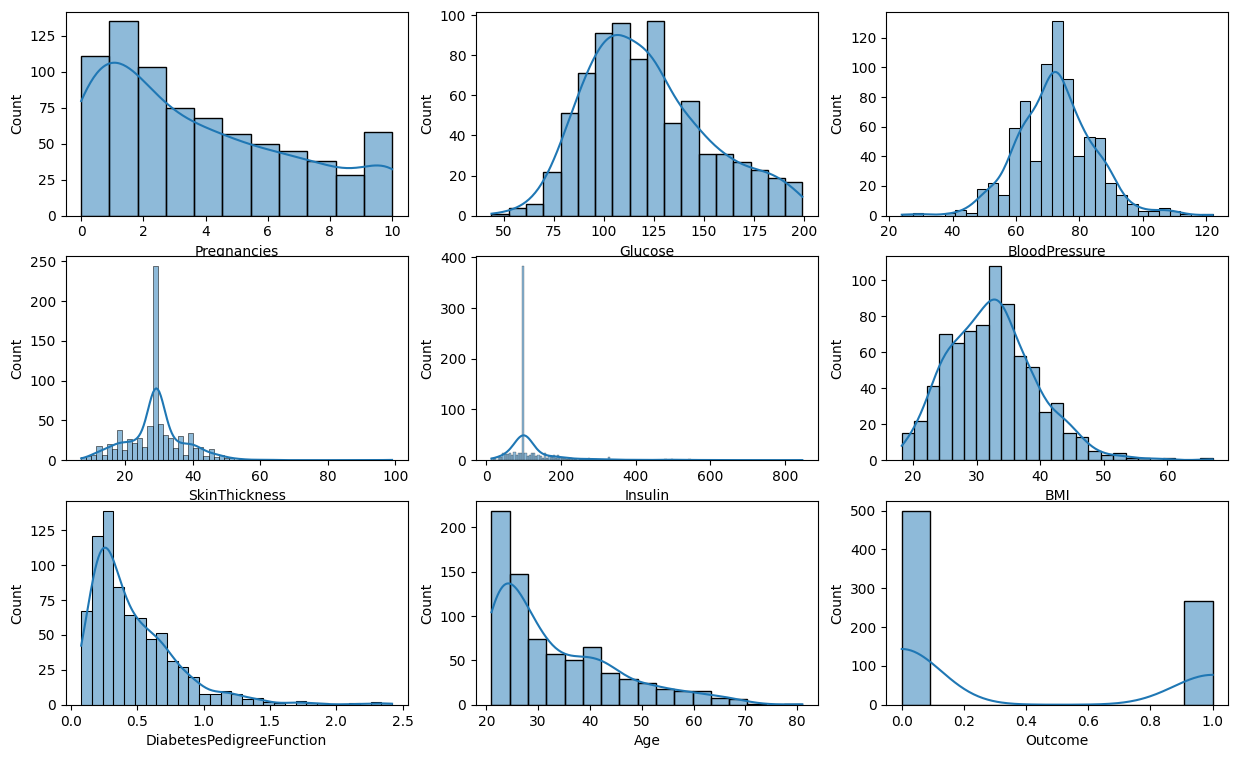

In [58]:
# Now draw plots and check the noisy data:
# first we check the data distribution:
%matplotlib inline
fig, ax = plt.subplots(3,3,figsize=(15,9))
for i, col in enumerate(df):
    sns.histplot(df[col], kde=True, ax=ax[i//3, i%3])
    # plt.title(f"{col} ditribution", fontsize=14, fontweight='bold', c='r')
plt.show()

# **Data Collection and Analysis**

## PIMA Diabetes Dataset

In [59]:
# printing the first 5 rows of the dataset
diabetes_dataset.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [60]:
# number of rows and Columns in this dataset
diabetes_dataset.shape

(768, 9)

In [61]:
# getting the statistical measures of the data
diabetes_dataset.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [62]:
diabetes_dataset['Outcome'].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

In [63]:
diabetes_dataset.groupby('Outcome').mean()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Outcome,,,,,,,,
0,3.298000,109.980000,68.184000,19.664000,68.792000,30.304200,0.429734,31.190000
1,4.865672,141.257463,70.824627,22.164179,100.335821,35.142537,0.550500,37.067164


In [64]:
# separating the data and labels
X = diabetes_dataset.drop(columns = 'Outcome', axis=1)
Y = diabetes_dataset['Outcome']

In [65]:
print(X)

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6      148             72             35        0  33.6   
1              1       85             66             29        0  26.6   
2              8      183             64              0        0  23.3   
3              1       89             66             23       94  28.1   
4              0      137             40             35      168  43.1   
..           ...      ...            ...            ...      ...   ...   
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60              0        0  30.1   
767            1       93             70             31        0  30.4   

     DiabetesPedigreeFunction  Age  
0                       0.627   50  
1                       0.351   31  


In [66]:
print(Y)

0      1
1      0
2      1
3      0
4      1
      ..
763    0
764    0
765    0
766    1
767    0
Name: Outcome, Length: 768, dtype: int64


### Data Standardization

In [67]:
scaler = StandardScaler()

In [68]:
scaler.fit(X)

StandardScaler()

In [69]:
standardized_data = scaler.transform(X)

In [70]:
print(standardized_data)

[[ 0.63994726  0.84832379  0.14964075 ...  0.20401277  0.46849198
   1.4259954 ]
 [-0.84488505 -1.12339636 -0.16054575 ... -0.68442195 -0.36506078
  -0.19067191]
 [ 1.23388019  1.94372388 -0.26394125 ... -1.10325546  0.60439732
  -0.10558415]
 ...
 [ 0.3429808   0.00330087  0.14964075 ... -0.73518964 -0.68519336
  -0.27575966]
 [-0.84488505  0.1597866  -0.47073225 ... -0.24020459 -0.37110101
   1.17073215]
 [-0.84488505 -0.8730192   0.04624525 ... -0.20212881 -0.47378505
  -0.87137393]]


In [71]:
X = standardized_data
Y = diabetes_dataset['Outcome']

In [72]:
print(X)
print(Y)

[[ 0.63994726  0.84832379  0.14964075 ...  0.20401277  0.46849198
   1.4259954 ]
 [-0.84488505 -1.12339636 -0.16054575 ... -0.68442195 -0.36506078
  -0.19067191]
 [ 1.23388019  1.94372388 -0.26394125 ... -1.10325546  0.60439732
  -0.10558415]
 ...
 [ 0.3429808   0.00330087  0.14964075 ... -0.73518964 -0.68519336
  -0.27575966]
 [-0.84488505  0.1597866  -0.47073225 ... -0.24020459 -0.37110101
   1.17073215]
 [-0.84488505 -0.8730192   0.04624525 ... -0.20212881 -0.47378505
  -0.87137393]]
0      1
1      0
2      1
3      0
4      1
      ..
763    0
764    0
765    0
766    1
767    0
Name: Outcome, Length: 768, dtype: int64


### Train Test Split

In [73]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, stratify=Y, random_state=2)

In [74]:
print(X.shape, X_train.shape, X_test.shape)

(768, 8) (614, 8) (154, 8)


### Training the Model

In [75]:
classifier = svm.SVC(kernel='linear')

In [76]:
#training the support vector Machine Classifier
classifier.fit(X_train, Y_train)

SVC(kernel='linear')

### Model Evaluation

**Accuracy Score**

In [77]:
# accuracy score on the training data
X_train_prediction = classifier.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction, Y_train)

In [78]:
print('Accuracy score of the training data : ', training_data_accuracy)

Accuracy score of the training data :  0.7866449511400652


In [79]:
# accuracy score on the test data
X_test_prediction = classifier.predict(X_test)
test_data_accuracy = accuracy_score(X_test_prediction, Y_test)

In [80]:
print('Accuracy score of the test data : ', test_data_accuracy)

Accuracy score of the test data :  0.7727272727272727


In [82]:
# Precision, Recall, and F1 score on the training data
training_precision = precision_score(Y_train, X_train_prediction)
training_recall = recall_score(Y_train, X_train_prediction)
training_f1 = f1_score(Y_train, X_train_prediction)

print('Precision score of the training data : ', training_precision)
print('Recall score of the training data : ', training_recall)
print('F1 score of the training data : ', training_f1)

# Precision, Recall, and F1 score on the test data
test_precision = precision_score(Y_test, X_test_prediction)
test_recall = recall_score(Y_test, X_test_prediction)
test_f1 = f1_score(Y_test, X_test_prediction)

print('Precision score of the test data : ', test_precision)
print('Recall score of the test data : ', test_recall)
print('F1 score of the test data: ', test_f1)

Precision score of the training data :  0.7455621301775148
Recall score of the training data :  0.5887850467289719
F1 score of the training data :  0.6579634464751958
Precision score of the test data :  0.7567567567567568
Recall score of the test data :  0.5185185185185185
F1 score of the test data:  0.6153846153846154


**Making** **the** **Prediction** **Model**

In [83]:
input_data = (5,166,72,19,175,25.8,0.587,51)

# changing the input_data to numpy array
input_data_as_numpy_array = np.asarray(input_data)

# reshape the array as we are predicting for one instance
input_data_reshaped = input_data_as_numpy_array.reshape(1,-1)

# standardize the input data
std_data = scaler.transform(input_data_reshaped)
print(std_data)

prediction = classifier.predict(std_data)
print(prediction)

if (prediction[0] == 0):
  print('The person is not diabetic')
else:
  print('The person is diabetic')

[[ 0.3429808   1.41167241  0.14964075 -0.09637905  0.82661621 -0.78595734
   0.34768723  1.51108316]]
[1]
The person is diabetic


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names



In [84]:

import pickle


filename = 'diabetes_model (6).sav'
pickle.dump(classifier, open(filename, 'wb'))


# loading the saved model
loaded_model = pickle.load(open('diabetes_model (6).sav', 'rb'))


input_data = (5,166,72,19,175,25.8,0.587,51)

# changing the input_data to numpy array
input_data_as_numpy_array = np.asarray(input_data)

# reshape the array as we are predicting for one instance
input_data_reshaped = input_data_as_numpy_array.reshape(1,-1)

prediction = loaded_model.predict(input_data_reshaped)
print(prediction)

if (prediction[0] == 0):
  print('The person is not diabetic')
else:
  print('The person is diabetic')

[1]
The person is diabetic


Support Vector Machine implemented without Python package

In [87]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score

class SVM:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        y_ = np.where(y <= 0, -1, 1)  # Convert labels to -1 and 1

        self.w = np.zeros(n_features)
        self.b = 0

        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition = y_[idx] * (np.dot(x_i, self.w) - self.b) >= 1
                if condition:
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.lr * (2 * self.lambda_param * self.w - np.dot(x_i, y_[idx]))
                    self.b -= self.lr * y_[idx]

    def predict(self, X):
        approx = np.dot(X, self.w) - self.b
        return np.sign(approx)

# Prepare the data
diabetes_dataset = pd.read_csv('/content/drive/MyDrive/Should Zip(1)/diabetes.csv')
X = diabetes_dataset.drop(columns='Outcome', axis=1).values
Y = diabetes_dataset['Outcome'].values

# Split the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=2)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the SVM classifier
classifier = SVM(learning_rate=0.001, lambda_param=0.01, n_iters=1000)
classifier.fit(X_train, Y_train)

# Predict and calculate accuracy
def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

X_train_prediction = classifier.predict(X_train)
training_data_accuracy = accuracy(Y_train, X_train_prediction)
print('Accuracy score of the training data : ', training_data_accuracy)

X_test_prediction = classifier.predict(X_test)
test_data_accuracy = accuracy(Y_test, X_test_prediction)
print('Accuracy score of the test data : ', test_data_accuracy)

# Transform predictions and true labels to 0 and 1 for metric calculation
X_train_prediction = np.where(X_train_prediction == -1, 0, 1)
X_test_prediction = np.where(X_test_prediction == -1, 0, 1)

# Precision, Recall, and F1 score on the training data
training_precision = precision_score(Y_train, X_train_prediction, average='binary')
training_recall = recall_score(Y_train, X_train_prediction, average='binary')
training_f1 = f1_score(Y_train, X_train_prediction, average='binary')

print('Precision score of the training data : ', training_precision)
print('Recall score of the training data : ', training_recall)
print('F1 score of the training data : ', training_f1)

# Precision, Recall, and F1 score on the test data
test_precision = precision_score(Y_test, X_test_prediction, average='binary')
test_recall = recall_score(Y_test, X_test_prediction, average='binary')
test_f1 = f1_score(Y_test, X_test_prediction, average='binary')

print('Precision score of the test data : ', test_precision)
print('Recall score of the test data : ', test_recall)
print('F1 score of the test data: ', test_f1)

# Predicting for a single instance
input_data = (5, 166, 72, 19, 175, 25.8, 0.587, 51)
input_data_as_numpy_array = np.asarray(input_data).reshape(1, -1)
std_data = scaler.transform(input_data_as_numpy_array)

prediction = classifier.predict(std_data)
print(prediction)

if (prediction[0] == -1):
    print('The person is not diabetic')
else:
    print('The person is diabetic')



Accuracy score of the training data :  0.20195439739413681
Accuracy score of the test data :  0.18181818181818182
Precision score of the training data :  0.7515151515151515
Recall score of the training data :  0.5794392523364486
F1 score of the training data :  0.6543535620052771
Precision score of the test data :  0.7567567567567568
Recall score of the test data :  0.5185185185185185
F1 score of the test data:  0.6153846153846154
[1.]
The person is diabetic
